***Dependencies***

In [1]:
# !pip install gpytorch
# !pip install botorch
# !pip install matplotlib

In [2]:
"""Import Statements which we will need"""
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.acquisition import IdentityMCObjective
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.objective import (
    IdentityMCObjective,
    MCAcquisitionObjective,
    PosteriorTransform,
)
from botorch.acquisition.objective import ConstrainedMCObjective
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_model
from botorch import fit_gpytorch_model

from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP, ModelListGP

from botorch.models.model import Model
from botorch.optim import optimize_acqf
from botorch.optim.initializers import initialize_q_batch_nonneg
from botorch.optim.optimize import optimize_acqf

from botorch.sampling import SobolQMCNormalSampler
from botorch.sampling import IIDNormalSampler
from botorch.sampling.samplers import MCSampler, SobolQMCNormalSampler
from botorch.test_functions import Beale, Branin, Hartmann 
# from botorch.test_functions.hartmann6 import neg_hartmann6
from botorch.utils import standardize
from botorch.utils import t_batch_mode_transform
from botorch.utils.transforms import (
    concatenate_pending_points,
    match_batch_shape,
    t_batch_mode_transform,
)

from gpytorch.kernels.matern_kernel import MaternKernel
from gpytorch.kernels.linear_kernel import LinearKernel
from gpytorch.kernels.piecewise_polynomial_kernel import PiecewisePolynomialKernel
from gpytorch.kernels.polynomial_kernel import PolynomialKernel
from gpytorch.kernels.rbf_kernel import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.priors.torch_priors import GammaPrior


from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from typing import Any, Dict, Optional, Tuple, Union
from torch import Tensor
from torch.distributions import Normal

import botorch
import gpytorch
import contextlib
import math
import numpy as np
import os
import random
import time
import torch
import warnings


## **1. Setup** 


In [3]:
'''Parameters for how the code runs
Note: true algorithm hyperparameters are defined in the main loop'''

# Add 5, asterisks `#*****`, to the end of any line we modified or added from -> ||  https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only '''

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning) #*****

Text(0.5, 1.0, 'logistic function')

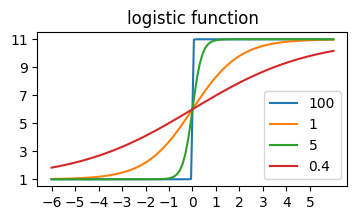

In [4]:
logistic = lambda z, const: 1./ (1 + np.exp(-const*z))       #logistic function
z = np.linspace(-6,6,100)
plt.subplots(1, 1, figsize=(4, 2))
plt.plot(z, logistic(z, 100)*10 + 1, label="100")
plt.plot(z, logistic(z, 1)*10 + 1, label="1")
plt.plot(z, logistic(z, 5)*10 + 1, label="5")
plt.plot(z, logistic(z, 0.4)*10 + 1, label="0.4")
plt.xticks(np.arange(-6,6,1))
plt.yticks(np.arange(1, 13, 2)) 
plt.legend(loc="lower right")

plt.title('logistic function')



## **2. Helper Functions** 


In [5]:
def normalize(val, norm_type=None, bounds=None): 
    if norm_type=='x': # we want in (0,1)
        X = val + 0 # neat computational copy of X 
        for dim in range(len(bounds[0])):
            X[:, dim] = (X[:, dim] - bounds[0][dim].item()) / (bounds[1][dim].item() - bounds[0][dim].item() ) # subtract the min bound and divide by the range to shift into (0,1)
        return X

    elif norm_type=='y' or norm_type=='c' or norm_type=='1/c':
        Y = val + 0 # we want in (-1,1)
        for dim in range(len(bounds[0])):
            Y[:, dim] = (Y[:, dim] - bounds[0][dim].item()) / (bounds[1][dim].item() - bounds[0][dim].item() ) # subtract the min bound and divide by the range to shift into (0,1)
        Y  = (Y * 2) - 1 
        return Y 

    else:
        raise Exception("Sorry, ONLY x, y, or c values can be normalised")


def unnormalize(val, norm_type, orig_bounds=None):
    if norm_type=='x': # from (0,1) to original bounds range
        X = val + 0 # neat computational copy of val 
        for dim in range(len(orig_bounds[0])): # from (0,1) to orig range
            X[:, dim] = X[:, dim] * (orig_bounds[1][dim].item() - orig_bounds[0][dim].item()) + (orig_bounds[0][dim].item()) 
        return X 

    elif norm_type=='y' or norm_type=='c' or norm_type=='1/c': # from (-1,1) to original bounds range; 
        # for cost values, we want to unnormalize in-between GP fitting and acq_fun optimisation
        Y = val + 0
        Y = (Y + 1) / 2 # normalise from (-1,1) into (0,1)
        for dim in range(len(orig_bounds[0])): # from (-1,1) to orig range
            Y[:, dim] = Y[:, dim] * (orig_bounds[1][dim].item() - orig_bounds[0][dim].item()) + (orig_bounds[0][dim].item()) 
        return Y 
    else:
        raise Exception("Sorry, ONLY x, y, or c values can be UNnormalised")

def objective(X, cfg={}):
    if cfg['fxn_name']=='test':
        assert X.shape[1] == cfg['fxn_dim'] 
        return -(torch.linalg.norm(X, dim=-1))  
    elif cfg['fxn_name']=='branin_4d':
        # print("X==>", X)
        assert X.shape[1] == cfg['fxn_dim'] 
        return cfg['neg_branin2'](X[:,:2]) + cfg['neg_branin2'](X[:,2:])
    elif cfg['fxn_name']=='branin_hartmann_8d':
        assert X.shape[1] == cfg['fxn_dim'] 
        return cfg['neg_branin2'](X[:,:2]) + cfg['neg_hartmann6'](X[:,2:]) 
    elif cfg['fxn_name']=='beale_hartmann_7d':
        assert X.shape[1] == cfg['fxn_dim']  
        return cfg['neg_beale2'](X[:,:2]) + cfg['neg_hartmann3'](X[:,2:5]) + cfg['neg_beale2'](X[:,5:])
    else:
        print("ERROR! NEED TO ASSIGN ONE OF THESE FUNCTIONS!") 
        
        
def get_random_observations(batch_size, bounds):
    # Build random observation one dimension at a time
    # This allows us to use different bounds for each hyperparameter
    rand_x = torch.distributions.uniform.Uniform(bounds[0][0],bounds[1][0]).sample([batch_size,1])
    for dim in range(1,len(bounds[0])):
        temp = torch.distributions.uniform.Uniform(bounds[0][dim],bounds[1][dim]).sample([batch_size,1]) 
        rand_x = torch.cat((rand_x, temp), dim=1)
    return rand_x 

def generate_initial_data(n, bounds, trial_seed=None, cfg={}): 
    torch.manual_seed(seed=trial_seed) 
    train_x = get_random_observations(batch_size=n, bounds=bounds)
    train_y = objective(train_x,cfg=cfg).unsqueeze(-1)  # add output dimension
    return train_x, train_y 


def sigmoid(z, const):
    return 1./ (1 + torch.exp(-const*z))*10 + 1

def generate_cost(train_x, cfg={}):  
    if cfg['fxn_name']=='test':
        assert train_x.shape[1] == cfg['fxn_dim'] 
        ret = sigmoid(train_x[:,0], 5) 
    elif cfg['fxn_name']=='branin_4d':
        assert train_x.shape[1] == cfg['fxn_dim'] 
        # ret = CONSTANT + (train_x[:,0])**2 + (train_x[:,2])**2 +  torch.sqrt(torch.abs(train_x[:,3]))  # this one had numerical issuse due to sqrt-why?!!
        # ret = CONSTANT + (train_x[:,0])**2 + (train_x[:,2])**2  
        # print("TRAIN_X (Cost)", train_x.shape, train_x[:,0].shape, train_x[:,2].shape, train_x[:,3].shape)
        ret = cfg['CONSTANT'] + sigmoid(train_x[:,0],5) + (train_x[:,2]) + (train_x[:,3]) 
    elif cfg['fxn_name']=='branin_hartmann_8d':
        assert train_x.shape[1] == cfg['fxn_dim'] 
        # ret = train_x[:,0] + (train_x[:,1])**2 + CONSTANT + torch.sqrt(torch.abs(train_x[:,4])) + train_x[:,5] + (train_x[:,6])**2 # this one had numerical issuse due to sqrt-why?!!
        ret = train_x[:,0] + (train_x[:,1])**2 + cfg['CONSTANT'] + train_x[:,5] + (train_x[:,6])**2  
    elif cfg['fxn_name']=='beale_hartmann_7d':
        assert train_x.shape[1] == cfg['fxn_dim']  
        ret = cfg['CONSTANT'] + (train_x[:,0]) + (train_x[:,1]) + (train_x[:,2]) + (train_x[:,3])**2 + (train_x[:,4])**2 + cfg['CONSTANT'] + (train_x[:,5]) + (train_x[:,6]) 
    else:
        print("ERROR! NEED TO ASSIGN ONE OF THESE FUNCTIONS!")
        ret = None
    return ret.unsqueeze(-1)  

def initialize_model(train_x, train_y, state_dict=None, cost_kernel=None ):
    init_x = train_x + 0
    init_y = train_y + 0

    model_obj = SingleTaskGP(init_x, init_y, covar_module=cost_kernel).to(init_x) # Just inheriting from PyTorch's module.to https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj) 
    return mll, model_obj 
 


def optimize_acqf_and_get_observation(batch_size, acq_func, optim_bounds=None, r_seed=None):
    """Optimizes the acquisition function, and returns a new candidate and observation."""
    if acq_func=="RAND":
        new_x = get_random_observations(batch_size, optim_bounds)
        return new_x 

    candidates, _ = optimize_acqf( # https://github.com/pytorch/botorch/issues/371
        acq_function=acq_func, 
        bounds=optim_bounds,
        q=batch_size,
        num_restarts=10,
        raw_samples=500,  # used for intialization heuristic
        # batch_initial_conditions=initials,
        options={ 
            "seed": r_seed
        }
    )
    # observe new values 
    new_x = candidates.detach()
    return new_x 

## **3. Helper Functions**  

In [6]:
### Code for EEIPU
class EIPUVariants(AnalyticAcquisitionFunction): 
    r"""Modification of Standard Expected Improvement Class defined in BoTorch
    See: https://botorch.org/api/_modules/botorch/acquisition/analytic.html#ExpectedImprovement
    """ 

    def __init__(
        self,
        model: Model,
        cost_model: Model,
        best_f: Union[float, Tensor],
        cost_sampler: Optional[MCSampler] = None,
        acq_objective: Optional[MCAcquisitionObjective] = None,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        acq_type: str = "", 
        cost_func = None,
        unnormalise_func = None,
        bounds: Tensor = None, # min, max
        cfg: Dict = None,
        **kwargs: Any,
    ) -> None:
        r"""q-Expected Improvement.

        Args:
            model: A fitted objective model.
            cost_model: A fitted cost model.
            best_f: The best objective value observed so far (assumed noiseless).  
            cost_sampler: The sampler used to draw base samples.  
            acq_objective: The MCAcquisitionObjective under which the samples are evaluated.
                Defaults to `IdentityMCObjective()`.
            posterior_transform: A PosteriorTransform (optional). 
            maximize: If True, consider the problem a maximization problem.
        """
        super().__init__(
            model=model,  
            posterior_transform=posterior_transform,
            **kwargs
        )
        self.maximize = maximize
        if not torch.is_tensor(best_f):
            best_f = torch.tensor(best_f)
        self.register_buffer("best_f", best_f)
        self.cost_model = cost_model
        self.cost_sampler = cost_sampler
        self.acq_obj = acq_objective  
        self.acq_type = acq_type
        self.cost_func = cost_func
        self.unnormalise_func = unnormalise_func
        self.bounds = bounds
        self.cfg = cfg

    def compute_expected_inverse_cost(self, X: Tensor) -> Tensor:
        r""" Custom function. 
        """
        cost_posterior = self.cost_model.posterior(X)
        cost_samples = self.cost_sampler(cost_posterior) 
        cost_samples = cost_samples.max(dim=2)[0]
        # Note: Unnormalize Sampled Cost Values Here
        if self.cfg['normalize_bit']['c']: # only unnormalize cost if we normalized it to fit the GP
            cost_samples = self.unnormalise_func(cost_samples, norm_type='c', orig_bounds=self.bounds['c']) 
        cost_obj = self.acq_obj(cost_samples)
        inv_cost =  1/cost_obj
        inv_cost =  inv_cost.mean(dim=0)
        return inv_cost


    def direct_expected_inverse_cost(self, X: Tensor) -> Tensor:
        r""" TO-DO.
        """
        cost_posterior = self.cost_model.posterior(X) 
        mean = cost_posterior.mean
        if self.cfg['normalize_bit']['1/c']: # only unnormalize cost if we normalized it to fit the GP
            mean = self.unnormalise_func(mean, norm_type='1/c', orig_bounds=self.bounds['1/c']) 
        return mean.squeeze()

    def compute_expected_cost(self, X: Tensor) -> Tensor:
        r""" Custom function.
        Used for debugging the return value of expected inverse cont function above.
        """
        cost_posterior = self.cost_model.posterior(X)
        cost_samples = self.cost_sampler(cost_posterior) 
        cost_samples = cost_samples.max(dim=2)[0]
        # Note: Unnormalize Sampled Cost Values Here
        if self.cfg['normalize_bit']['c']: # only unnormalize cost if we normalized it to fit the GP
            cost_samples = self.unnormalise_func(cost_samples, norm_type='c', orig_bounds=self.bounds['c']) 
        cost_obj = self.acq_obj(cost_samples) 
        return cost_obj.mean(dim=0)

    @t_batch_mode_transform(expected_q=1, assert_output_shape=False)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate qExpectedImprovement on the candidate set `X`.
        """ 
        self.best_f = self.best_f.to(X)
        posterior = self.model.posterior(
          X=X, posterior_transform=self.posterior_transform
        )
        mean = posterior.mean
        view_shape = mean.shape[:-2] if mean.shape[-2] == 1 else mean.shape[:-1]
        mean = mean.view(view_shape)
        sigma = posterior.variance.clamp_min(1e-9).sqrt().view(view_shape)
        u = (mean - self.best_f.expand_as(mean)) / sigma
        if not self.maximize:
            u = -u
        normal = Normal(torch.zeros_like(u), torch.ones_like(u))
        ucdf = normal.cdf(u)
        updf = torch.exp(normal.log_prob(u))
        ei = sigma * (updf + u * ucdf)
        if self.acq_type == "EIPU":
            if self.cfg['normalize_bit']['x']: # if X was normalized pre-GP-fit, unnormalize for true cost calculation
                X_new = self.unnormalise_func(X.squeeze(1) + 0, norm_type='x', orig_bounds=self.bounds['x'])   
                return ei / self.cost_func(X_new, cfg=self.cfg).squeeze()  
            return ei / self.cost_func(X.squeeze(1), cfg=self.cfg).squeeze() # otherwise just calculate cost straightup
     
        elif self.acq_type == "EEIPU":
            inv_cost =  self.compute_expected_inverse_cost(X)
            return ei * inv_cost
      
        elif self.acq_type == "EEIPU-INV":
            inv_cost = self.direct_expected_inverse_cost(X)
            return ei * inv_cost
        else:
            raise Exception("ERROR: Only EIPU, EEIPU, EEIPU-INV are supported!")

## **4. Single BO Step**  

In [7]:
def single_bo_iteration(dataset={}, bounds={}, acq_type='', cfg={}):
    cost_model, cost_sampler={}, {}
    # (A) Normalize the dataset Points (only normalize cost if we are using acqfunc that needs cost model)
    # NOTE: single-line if statements used here
    train_x = normalize(dataset['x'], norm_type='x', bounds=bounds['x']) if cfg['normalize_bit']['x'] else dataset['x']
    train_obj = normalize(dataset['y'], norm_type='y', bounds=bounds['y'])  if cfg['normalize_bit']['y'] else dataset['y']
    if acq_type=='EEIPU': # cover potential cost model value normalisation
        train_cost = normalize(dataset['c'], norm_type='c', bounds=bounds['c']) if cfg['normalize_bit']['c'] else dataset['c']
    if acq_type=='EEIPU-INV': # cover potential inverse cost model value normalisation
        train_cost = normalize(dataset['1/c'], norm_type='1/c', bounds=bounds['1/c']) if cfg['normalize_bit']['1/c'] else dataset['1/c']

    # (B) Initialise/Re-initialize & Fit/Refit the GP models (only initialise cost model if we'll need it)
    mll, model= initialize_model(train_x, train_obj) 
    fit_gpytorch_model(mll);
    if acq_type in ['EEIPU', 'EEIPU-INV']: 
        cost_mll, cost_model= initialize_model(train_x, train_cost, cost_kernel=cfg['cost_kernel'])  
        fit_gpytorch_model(cost_mll)

    # (C) Redefine acquisition function & optimise  
    if (acq_type=='RAND'):
        acqf = 'RAND'
    elif (acq_type=='EI'):
        acqf = ExpectedImprovement(model=model, best_f=train_obj.max())
    elif (acq_type=='EIPU') or (acq_type=='EEIPU') or (acq_type=='EEIPU-INV'):
        cost_sampler = SobolQMCNormalSampler(num_samples=cfg['cost_samples'], resample=True, seed=cfg['rand_seed'])
        acqf = EIPUVariants(acq_type=acq_type, model=model, cost_model=cost_model, 
                 best_f=train_obj.max(), 
                 cost_sampler=cost_sampler, acq_objective=IdentityMCObjective(),   
                 cost_func=generate_cost, unnormalise_func=unnormalize, bounds=bounds,
                 cfg=cfg)
 
    if acq_type == 'RAND':
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acq_type, 
                                              optim_bounds=bounds['x'], r_seed=cfg['rand_seed']) # includes random search option, for code neatness 
    else: # careful with bounds for non random acqfunctions - single line if statement used here
        normalised_bounds = normalize(bounds['x'], norm_type='x', bounds=bounds['x']) if cfg['normalize_bit']['x'] else bounds['x']  # Need too normalize the bounds used in the acqfunction too!
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acqf,  # includes random search option, for code neatness 
                                            optim_bounds=normalised_bounds, r_seed=cfg['rand_seed'])
    # (D) Unnormalize the X value and return (also mc value since we can't compute outside this func)
    cost_model_mean = torch.tensor([0]); 
    if acq_type == 'EEIPU': cost_model_mean = acqf.compute_expected_cost(new_x)
    if acq_type == 'EEIPU-INV': cost_model_mean = acqf.direct_expected_inverse_cost(new_x)
    if cfg['normalize_bit']['x'] and acq_type != 'RAND' : new_x = unnormalize(new_x, norm_type='x', orig_bounds=bounds['x'])# cat with unnormalised x here
    return new_x, cost_model_mean.item()
   


## **5.0 BO Inner Loops (Multiple Steps)**  

In [8]:
def bo_inner_loops(trial_number=None, x_bounds=None, acq_type='', cfg={}):
    print(f"TRIAL #{trial_number} Acq-Type: [{acq_type}]")
    log_vals  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], '1/c(x)': [], 'c(c)':[]} # f(x^) = best obj val so far; c(c) is cumulative cost  

    dataset, bounds = {},{}
    # (A) Initialize dataset for all the different acq function types  
    dataset['x'], dataset['y'] = generate_initial_data(n=cfg['num_initial_data'], bounds=x_bounds, trial_seed=trial_number, cfg=cfg); 
    dataset['c'] = generate_cost(dataset['x'], cfg=cfg) 
    dataset['1/c'] = 1/dataset['c'] 

    log_vals['c(c)'].append(dataset['c'].sum().item())
    log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())

    # (B) run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(cfg['n_iters']):    
        bounds['x'] = x_bounds # bounds written as min,max not max,min
        bounds['y'] = torch.tensor([[dataset['y'].min()], [dataset['y'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['c'] = torch.tensor([[dataset['c'].min()], [dataset['c'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['1/c'] = torch.tensor([[dataset['1/c'].min()], [dataset['1/c'].max()]], device=cfg['device'], dtype=cfg['dtype'])

        # (B.0) At each single iteration, we pass the dataset and take the next suggested point
        new_x, mc_x = single_bo_iteration(dataset=dataset, bounds=bounds, acq_type=acq_type, cfg=cfg )

        new_obj = objective(new_x, cfg=cfg).unsqueeze(-1)  # add output dimension 
        new_cost = generate_cost(new_x, cfg=cfg)  

        dataset['x'] = torch.cat([dataset['x'], new_x]) 
        dataset['y'] = torch.cat([dataset['y'], new_obj])  
        dataset['c'] = torch.cat([dataset['c'], new_cost])       
        dataset['1/c'] = torch.cat([dataset['1/c'], 1/new_cost])       

        log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())
        log_vals['x'] = np.array(new_x.cpu())
        log_vals['f(x)'].append(new_obj.item())
        log_vals['c(x)'].append(new_cost.item())
        log_vals['c(c)'].append(log_vals['c(c)'][-1]+ new_cost.item())
        log_vals['mc(x)'] = mc_x
        log_vals['1/c(x)'].append((1/new_cost).item())

        if cfg['verbose']:
            print(f"Iteration-{iteration} [{acq_type}] Trial No. #{trial_number}"
              f"\nf(x^)={log_vals['f(x^)'][-1]:>4.3f}"
              f"\tf(x)={log_vals['f(x)'][-1]:>4.3f}"
              f"\tc(x) = {log_vals['c(x)'][-1]:>4.3f}"
              f"\tmc(x) = {log_vals['mc(x)']:>4.3f}" 
              f"\t1/c(x) = {log_vals['1/c(x)'][-1]:>4.3f}" 
              f"\tc(c) = {log_vals['c(c)'][-1]:>4.3f}")

    return log_vals

## **5.1. BO Outer Loops (Multiple Trials)**  

In [9]:
def bo_trials(cfg={}, acq_type=''):

    torch.manual_seed(seed=cfg['rand_seed'])
    np.random.seed(cfg['rand_seed'])
    random.seed(cfg['rand_seed'])
    botorch.utils.sampling.manual_seed(seed=cfg['rand_seed'])
    # https://github.com/pytorch/botorch/issues/371


    x_bounds = torch.tensor([[cfg['x_bounds'][0]] * cfg['fxn_dim'], [cfg['x_bounds'][1]] * cfg['fxn_dim']], device=cfg['device'], dtype=cfg['dtype'])
    log_vals_all  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], 'c(c)':[]}
    print("\n\nnormalize_bit", cfg['normalize_bit'])
    # average over multiple trials
    for trial in range(1, cfg['n_trials'] + 1):

        log_vals = bo_inner_loops(trial_number=trial, x_bounds=x_bounds, acq_type=acq_type, cfg=main_cfg)

        for key in log_vals_all.keys():
            print("KEY->", key)
            log_vals_all[key].append(log_vals[key])
            if trial==cfg['n_trials']: log_vals_all[key] = np.array(log_vals_all[key])# save as np array on the last trial    
    return log_vals_all



## **5.2. BO Methods (Multiple Acquisitions)**  

In [10]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 2080 Ti


In [ ]:
# Batch size in original tutorial meant q-batch size https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only ||  # lower bound and upper bound could be -float('inf') ~ float('inf')
main_cfg = {
'batch_size':1, 'x_bounds': [-5,5],  
'CONSTANT':.5,
'cost_samples': 50, # mc cost samples
'cost_kernel': None, 
'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"), 'dtype': torch.double,
'fxn_name':'branin_4d', # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'fxn_dim':4, # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'neg_hartmann6':Hartmann(negate=True),
'neg_beale2':Beale(negate=True),
'neg_branin2':Branin(negate=True),
'neg_hartmann3':Hartmann(dim=3, negate=True), 
'n_trials':10,
'n_iters':30,
'num_initial_data':10,
'verbose':True,
'normalize_bit':{'x':True, 'y':True, 'c':True, '1/c':True}, 
'rand_seed': 0,
}
 
# (C) Do the above for each of the different acquisition function types
plot_vals = {}

plot_vals['RAND'] = bo_trials(cfg=main_cfg, acq_type='RAND') 
# plot_vals['RAND2'] = bo_trials(cfg=main_cfg, acq_type='RAND')  
plot_vals['EI'] = bo_trials(cfg=main_cfg, acq_type='EI') 
plot_vals['EIPU'] = bo_trials(cfg=main_cfg, acq_type='EIPU') 
plot_vals['EEIPU'] = bo_trials(cfg=main_cfg, acq_type='EEIPU') 
plot_vals['EEIPU-INV'] = bo_trials(cfg=main_cfg, acq_type='EEIPU-INV') 
# dfsdsdfsd




normalize_bit {'x': True, 'y': True, 'c': True, '1/c': True}
TRIAL #1 Acq-Type: [RAND]
Iteration-0 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-247.106	c(x) = 7.384	mc(x) = 0.000	1/c(x) = 0.135	c(c) = 78.636
Iteration-1 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-33.581	c(x) = 13.877	mc(x) = 0.000	1/c(x) = 0.072	c(c) = 92.512
Iteration-2 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-88.179	c(x) = 10.889	mc(x) = 0.000	1/c(x) = 0.092	c(c) = 103.401
Iteration-3 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-73.974	c(x) = 10.966	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 114.367
Iteration-4 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-58.352	c(x) = 10.694	mc(x) = 0.000	1/c(x) = 0.094	c(c) = 125.061
Iteration-5 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-122.731	c(x) = 8.220	mc(x) = 0.000	1/c(x) = 0.122	c(c) = 133.282
Iteration-6 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-130.491	c(x) = 2.670	mc(x) = 0.000	1/c(x) = 0.374	c(c) = 135.952
Iteration-7 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-45.071	c(x) = 9.963	mc(x) = 0.000	1/c(x) =

## **6.0. Plotting and Value Analyses**  

In [ ]:
# from botorch.test_functions.hartmann6 import GLOBAL_MAXIMUM

%matplotlib inline
def ci(y):
    # return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    return y.std(axis=0) 

# GLOBAL_MAXIMUM = 3.32237
GLOBAL_MAXIMUM = 0
iters = np.arange(main_cfg['n_iters']+1) * main_cfg['batch_size']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 4))

ax1.plot([0, main_cfg['n_iters'] * main_cfg['batch_size'] ], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)

types = ['RAND', 'EI', 'EIPU','EEIPU','EEIPU-INV',] 
 
for type_ in types:
    ax1.errorbar(iters, plot_vals[type_]['f(x^)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['f(x^)']), label=type_, linewidth=1) 
    # Can exclude cumumulative cost of random warmup points using `[:,1:]`, of course
    ax2.errorbar(plot_vals[type_]['c(c)'].mean(axis=0), plot_vals[type_]['f(x^)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['f(x^)']), label=type_, linewidth=1) 
    ax3.plot(plot_vals[type_]['c(x)'].mean(axis=0), plot_vals[type_]['f(x^)'][:,1:].mean(axis=0), 
              label=type_, linewidth=1)
    ax4.errorbar(plot_vals[type_]['f(x^)'].mean(axis=0), plot_vals[type_]['c(c)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['c(c)']), label=type_, linewidth=1.5)
    ### Use this to replace error bars with fill
    # ax3.fill_between(cum_cost_ei.mean(axis=0), y1=y_ei.mean(axis=0)-y_ei.std(axis=0), y2=y_ei.mean(axis=0)+y_ei.std(axis=0), label="EI", alpha=.5, linewidth=0)
    # ax1.set_xlim(right=20); # ax1.set_ylim(bottom=0.5); 

ax1.set(xlabel='number of observations (beyond initial points)', ylabel='Best Objective Value')
ax1.legend(loc="lower right")
ax2.set(xlabel='Cumulative Cost of observations', ylabel='Best Objective Value')
ax2.legend(loc="lower right")  
ax3.set(xlabel='Cost of observations', ylabel='Best Objective Value')
ax3.legend(loc="lower right")
ax4.set(xlabel='Best Objective Value', ylabel='Cumulative Cost of observations')
ax4.legend(loc="lower right")
 